In [561]:
## Questa è l'analisi preliminare eseguita sui dati
## Elimina i dati registrati da misurazioni sbagliate o imprecise
## Aumenta il dataset con dati derivati a partire da dati presenti

In [562]:
## import librerie

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import LineString


## creazione df

df1= pd.read_csv("data/gps-22-12-2024.csv",
    usecols=[0, 1, 2, 3, 4, 5, 6 ,7], 
    names=["unixtime", "latitudine", "longitudine", "altitudine", "boh1", "boh2", "precisione_orizzontale", "precisione_verticale"] ## 
    )

## righe duplicate in unixtime
df1 = df1[df1.duplicated(subset="unixtime", keep='first') == False]


In [563]:
## 

## Aggiunge colonna "delta_tempo"

def aggiungi_delta_tempo(gdf):
    gdf['delta_tempo'] = gdf['unixtime'].diff()
    
    return gdf

def aggiungi_delta_distanza(gdf):
    ## calcola la distanza orizzontale (non tiene conto del dislivello)
    gdf['distanza_orizzontale'] = gdf.geometry.distance(gdf.geometry.shift())  # shift: prende punto successivo

    ## calcola la distanza reale 3D usando Pitagora: i = sqrt(c1^2 + c2^2)
    gdf['distanza_reale'] = np.sqrt(
        gdf['distanza_orizzontale']**2 + (gdf['altitudine'].diff())**2
    )

    gdf['distanza_reale'] = gdf['distanza_reale'].fillna(0)
    gdf['distanza_orizzontale'] = gdf['distanza_orizzontale'].fillna(0)


    return gdf

def aggiungi_velocita(gdf):

    gdf['velocita']= gdf['distanza_reale'] / gdf['delta_tempo']
    gdf['velocita'] = gdf['velocita'].fillna(0)

    return gdf

def aggiungi_accelerazione(gdf):

    gdf['delta_velocita'] = gdf['velocita'].diff()
    gdf['delta_velocita'] = gdf['delta_velocita'].fillna(0)

    gdf['accelerazione'] = gdf['delta_velocita'] / gdf['delta_tempo']
    gdf['delta_velocita'] = gdf['delta_velocita'].fillna(0)
    
    return gdf

def aggiungi_pendenza(gdf):
    gdf['delta_altitudine'] = gdf['altitudine'].diff()

    gdf['pendenza'] = np.degrees(np.arctan(gdf['delta_altitudine'] / gdf['distanza_orizzontale']))
    gdf['pendenza'] = gdf['pendenza'].fillna(0)
    
    return gdf


def aggiungi_accelerazione_max(gdf):
    # Converti la pendenza da gradi a radianti
    gdf['pendenza_radianti'] = np.radians(gdf['pendenza'])

    # Calcola l'accelerazione massima teorica
    gdf['accelerazione_max'] = 9.81 * np.sin(gdf['pendenza_radianti'])

    return gdf


def filtra_punti_temporalmente(gdf, min_tempo=2):

    # Lista per le righe da mantenere
    valid_rows = [0]  # Mantieni sempre il primo punto

    # Itera attraverso i punti
    for i in range(1, len(gdf)):
        # Calcola il tempo tra il punto corrente e l'ultimo punto valido
        delta_tempo = gdf.iloc[i]['unixtime'] - gdf.iloc[valid_rows[-1]]['unixtime']
        
        # Se la differenza di tempo è sufficiente, aggiungi il punto alla lista
        if delta_tempo >= min_tempo:
            valid_rows.append(i)
    
    # Filtra il DataFrame
    gdf_filtrato = gdf.iloc[valid_rows].reset_index(drop=True)
    
    return gdf_filtrato

def filtro_precisione(gdf, precisione_orizzontale, precisione_verticale):

    gdf_filtrato = gdf.loc[
        (gdf['precisione_orizzontale'] <= precisione_orizzontale) &
        (gdf['precisione_verticale'] <= precisione_verticale)
    ].reset_index(drop=True)
    
    return gdf_filtrato

In [564]:
# Funzione per trovare intersezioni con vincolo temporale (5 minuti)
def find_intersecting_points(df, max_time_diff=60*1):
    points_to_remove = []  ## Lista per i punti da rimuovere
    segments = [] ## i segmenti che uniscono 2 punti

    ## crea segmenti
    for i in range(len(df) - 1):
        ## un segmento è fatto dal punto d'inizio e il punto di fine con relativi timestamp
        point1 = (df.loc[i, "longitudine"], df.loc[i, "latitudine"])
        point2 = (df.loc[i + 1, "longitudine"], df.loc[i + 1, "latitudine"])
        time1 = df.loc[i, "unixtime"]
        time2 = df.loc[i + 1, "unixtime"]

        ## il segmento diventa un tipo LineString
        segment = LineString([point1, point2])

        ## aggiunge il segmento con i timestamp e gli indici
        segments.append((   segment, 
                            time1, 
                            time2, 
                            i, 
                            i + 1))  

    ## controlla le intersezioni
    for i in range(len(segments)):
        j = i + 2   ## partiamo dal segmento successivo, 
                    ## 2 punti più in la per evitare intersezioni in un punto singolo!!!

        while j < len(segments) and abs(segments[i][2] - segments[j][1]) <= max_time_diff:  
            segment1 = segments[i][0]  ## il primo valore della tupla è un segmento
            segment2 = segments[j][0]  

            if segment1.intersects(segment2):  ## se si intersecano
                points_to_remove.append(segments[i][4])  ## elimina i punti di indice i e j
                #points_to_remove.append(segments[j][3])  ## [3]: i [4]:i+1 

            j += 1  # Passa al segmento successivo

    return points_to_remove


In [565]:
## inserimento colonna per dati geospaziali

gdf1= gpd.GeoDataFrame(
    df1, 
    geometry= gpd.points_from_xy(df1['longitudine'], df1['latitudine']),
    crs= "EPSG:4326"  ## le coordinate usano gradi
)

gdf1 = gdf1.to_crs("EPSG:3857")

time_start = df1['unixtime'][0]

In [566]:
gdf1 = filtro_precisione(gdf1, precisione_orizzontale=15, precisione_verticale= 15)

# Trova i punti da rimuovere con vincolo temporale
outlier_indices = find_intersecting_points(gdf1)

# Crea il dataset pulito
#gdf1 = gdf1.drop(outlier_indices).reset_index(drop=True)


In [567]:
## Questa sezione aggiunge informazioni derivate al dataset

gdf1 = aggiungi_delta_tempo(gdf1)

gdf1= aggiungi_delta_distanza(gdf1)

gdf1= aggiungi_velocita(gdf1)

gdf1 = aggiungi_accelerazione(gdf1)

gdf1= aggiungi_pendenza(gdf1)

gdf1= aggiungi_accelerazione_max(gdf1)

In [ ]:

## gdf1 = filtra_punti_temporalmente(gdf1, min_tempo=1) TAGLIA TROPPI DATI


In [ ]:
################################################################################
# Questa sezione di codice permette di selezionare un istante di tempo preciso
# su cui eseguire un analisi approfondita per testare la bonta dei dati
# TLDR: solo per debug
###############################################################################


# Esempio di utilizzo con un DataFrame (gdf1)

#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 22000) & (gdf1['unixtime'] - time_start<= 24000)].reset_index(drop=True)

#gdf1=alt_DBSCAN(gdf1, eps=0.1, min_samples=7)
#gdf1=geo_DBSCAN(gdf1, eps=0.5, min_samples=10)
#gdf1=distanza_reale_DBSCAN(gdf1, eps=0.5, min_samples=7)
#gdf1=velocita_DBSCAN(gdf1, eps=0.05, min_samples=7)
#
#gdf1 = aggiungi_delta_tempo(gdf1)
#
#gdf1= aggiungi_delta_distanza(gdf1)
#
#gdf1= aggiungi_velocita(gdf1)
#
#gdf1 = aggiungi_accelerazione(gdf1)
#
#gdf1= aggiungi_pendenza(gdf1)
#
#gdf1= aggiungi_accelerazione_max(gdf1)
#

##gdf1[['longitudine', 'latitudine', 'altitudine', 'distanza_reale', 'velocita', 'delta_tempo']].describe()

,longitudine,latitudine,altitudine,distanza_reale,velocita,delta_tempo
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,12.924313,46.514194,1201.939868,21.972950,12.409067,5.994018
std,0.005109,0.003792,262.024468,7.581408,5.626438,39.338420
min,12.915233,46.507084,822.514408,14.564349,0.089331,0.986000
25%,12.920017,46.511583,967.476536,16.400052,8.950586,1.003000
50%,12.925086,46.513032,1171.169051,20.226905,13.112334,2.000000
75%,12.928627,46.517435,1420.034890,25.073614,15.822984,2.005000
max,12.932420,46.521596,1792.727458,84.765332,25.553384,630.783000


In [570]:
## Salva i dati in un file 
gdf1.to_csv('data/gdf1.csv', index=False)

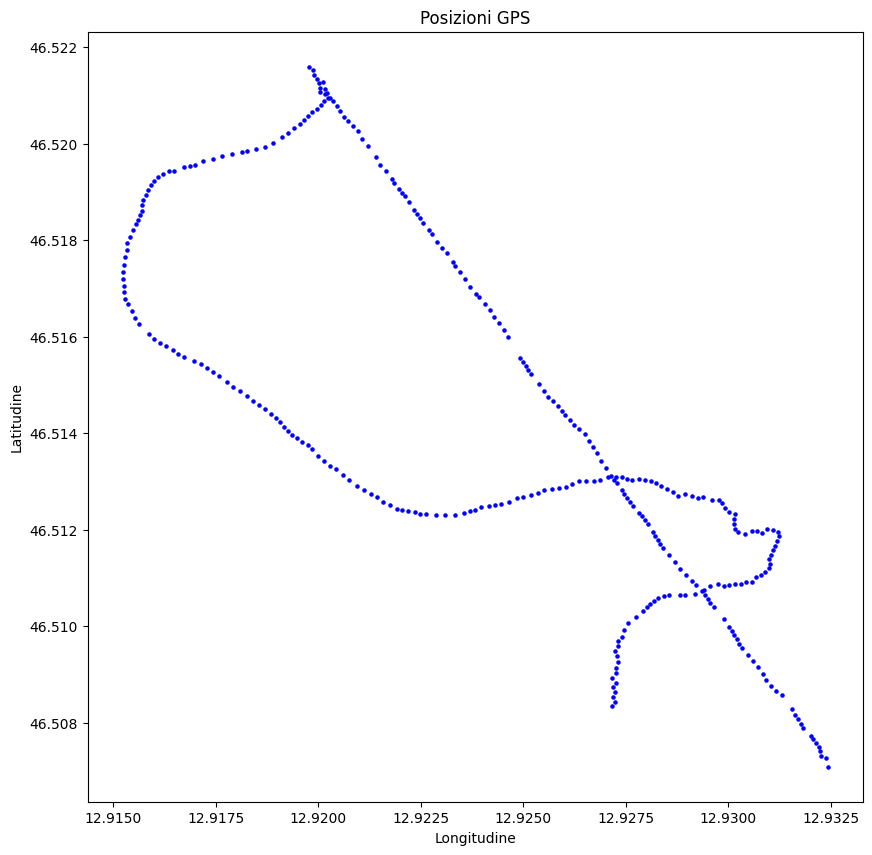

In [571]:


# Esempio di dati (usa i tuoi dati)
latitudini = gdf1['latitudine']
longitudini = gdf1['longitudine']

# Crea il grafico con uno sfondo bianco
plt.figure(figsize=(10, 10))
plt.scatter(longitudini, latitudini, color='blue', marker='o', s=5)  # s è la dimensione dei punti
plt.title("Posizioni GPS")
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
#plt.ylim(46.520, 46.525)

# Impostazioni per lo sfondo bianco 
plt.gca().set_facecolor('white')

plt.show()

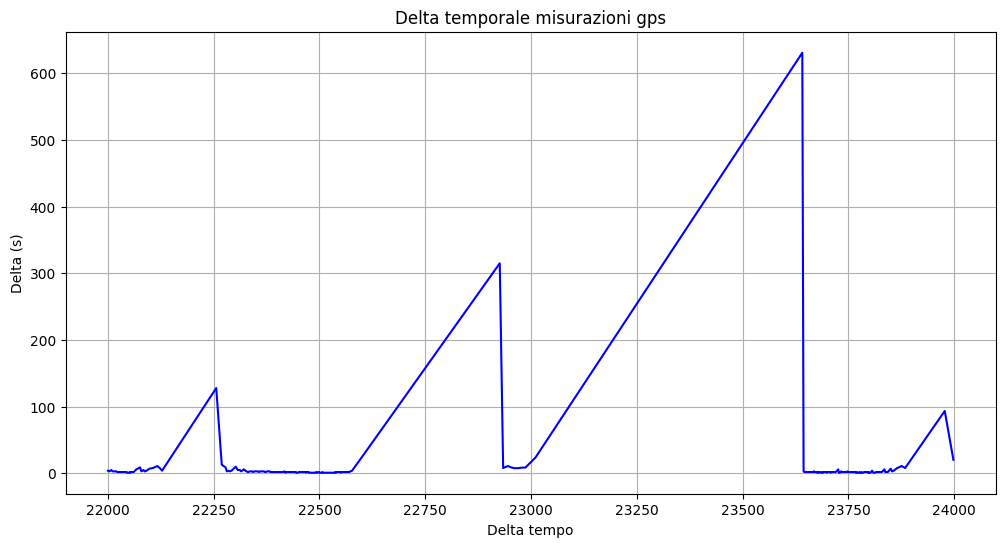

count    334.000000
mean       5.994018
std       39.338420
min        0.986000
25%        1.003000
50%        2.000000
75%        2.005000
max      630.783000
Name: delta_tempo, dtype: float64

In [572]:
## Delta tempo


plt.figure(figsize=(12, 6))
plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['delta_tempo'], 
    label='Intervallo di tempo tra misurazioni', 
    color='blue'
    )

plt.xlabel('Delta tempo')
plt.ylabel('Delta (s)')
plt.title('Delta temporale misurazioni gps')
plt.grid(True)
#plt.ylim(0, 600)  ## max 600 secondi-> 10 minuti di pausa
#plt.xlim(12000, 16500)

plt.show()

gdf1["delta_tempo"].describe()


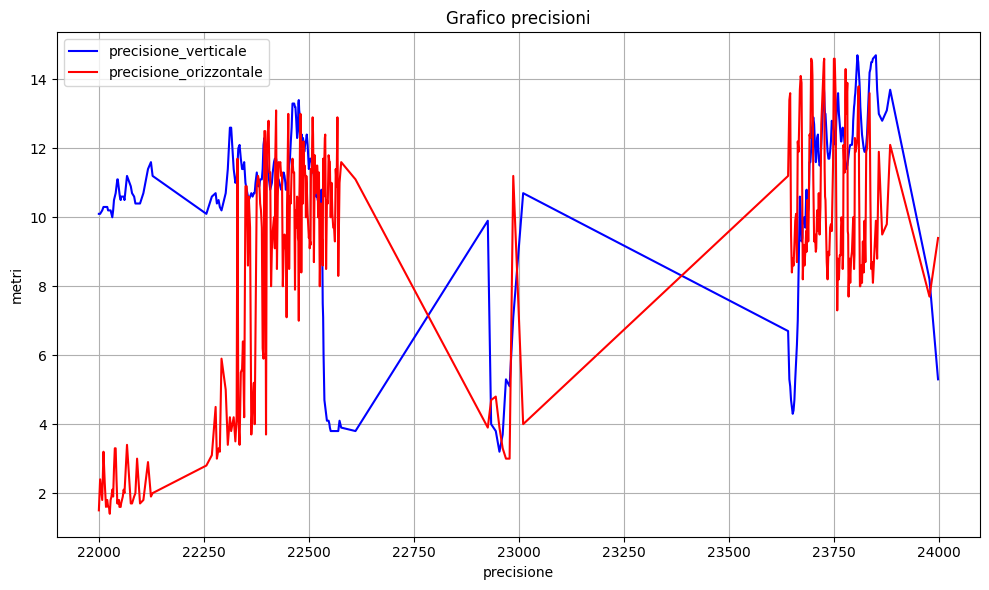

In [573]:
## Altimetria della giornata


plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['precisione_verticale'], 
    label='precisione_verticale', 
    color='blue')

plt.plot(
    gdf1['unixtime'] - time_start, 
    gdf1['precisione_orizzontale'], 
    label='precisione_orizzontale', 
    color='red'
)

plt.xlabel('precisione')
plt.ylabel('metri')
plt.title('Grafico precisioni')
plt.grid(True)
plt.legend()
#plt.ylim(0,50)

# Mostrare il grafico
plt.tight_layout()
plt.show()


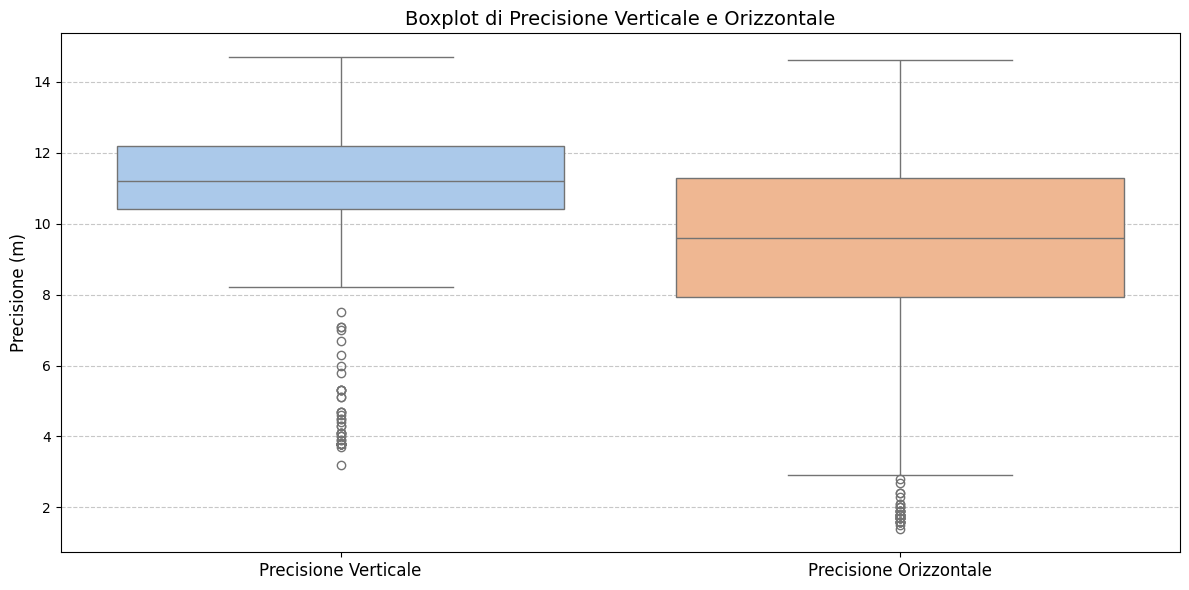

In [574]:
plt.figure(figsize=(12, 6))

# Crea i boxplot affiancati
sns.boxplot(data=gdf1[['precisione_verticale', 'precisione_orizzontale']], palette='pastel')

# Aggiungi titolo e etichette
plt.title('Boxplot di Precisione Verticale e Orizzontale', fontsize=14)
plt.ylabel('Precisione (m)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Precisione Verticale', 'Precisione Orizzontale'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.tight_layout()
plt.show()


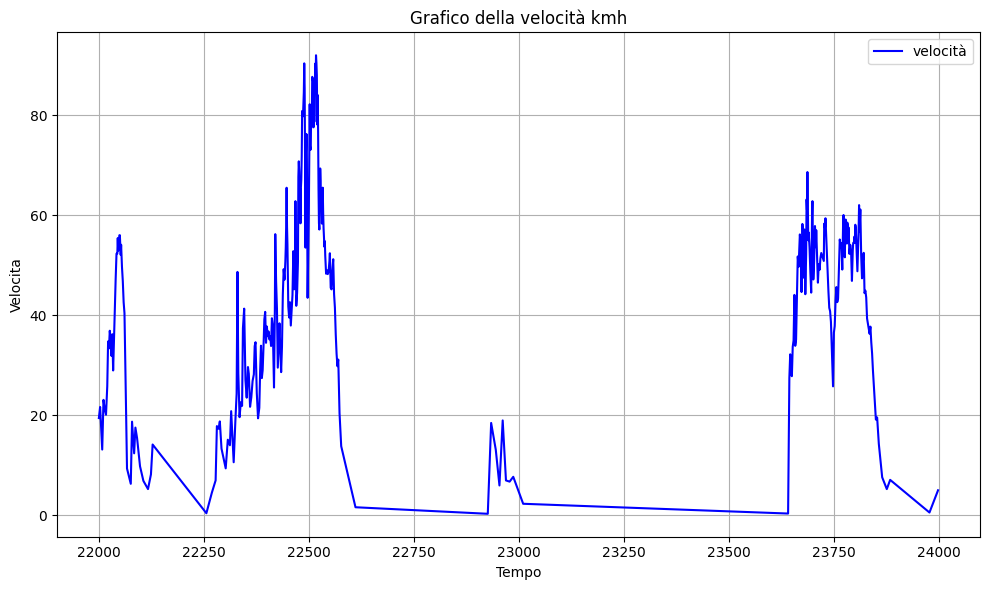

In [575]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['velocita'] * 3.6, 
    label='velocità', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Velocita')
plt.title('Grafico della velocità kmh')
plt.grid(True)
plt.legend()
#plt.ylim(0,200)
#plt.xlim(24300, 24600)  ## max 600 secondi-> 10 minuti di pausa

# Mostrare il grafico
plt.tight_layout()
plt.show()

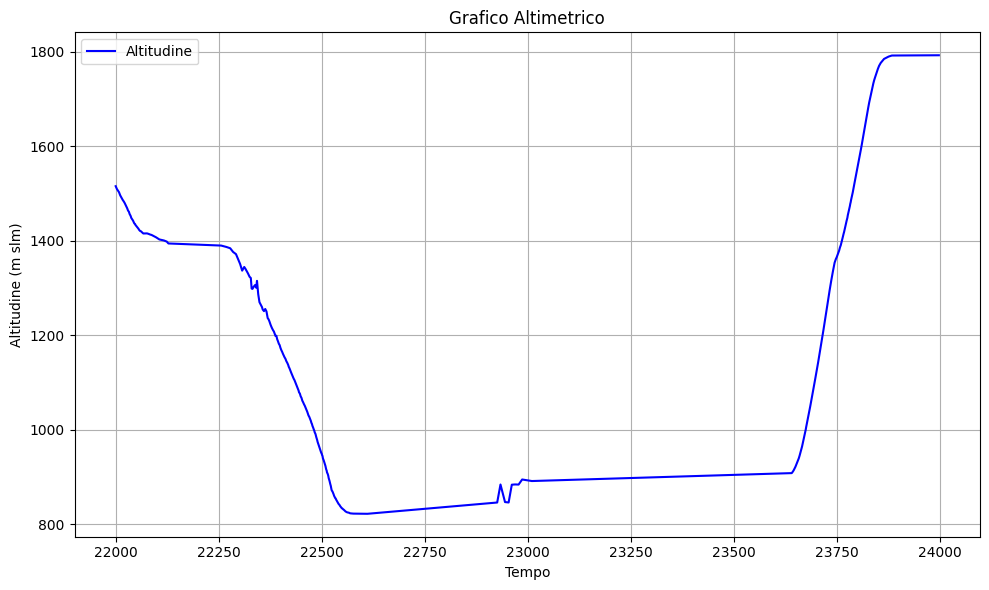

In [576]:
## Altimetria della giornata


plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['altitudine'], 
    label='Altitudine', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')
plt.title('Grafico Altimetrico')
plt.grid(True)
plt.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()


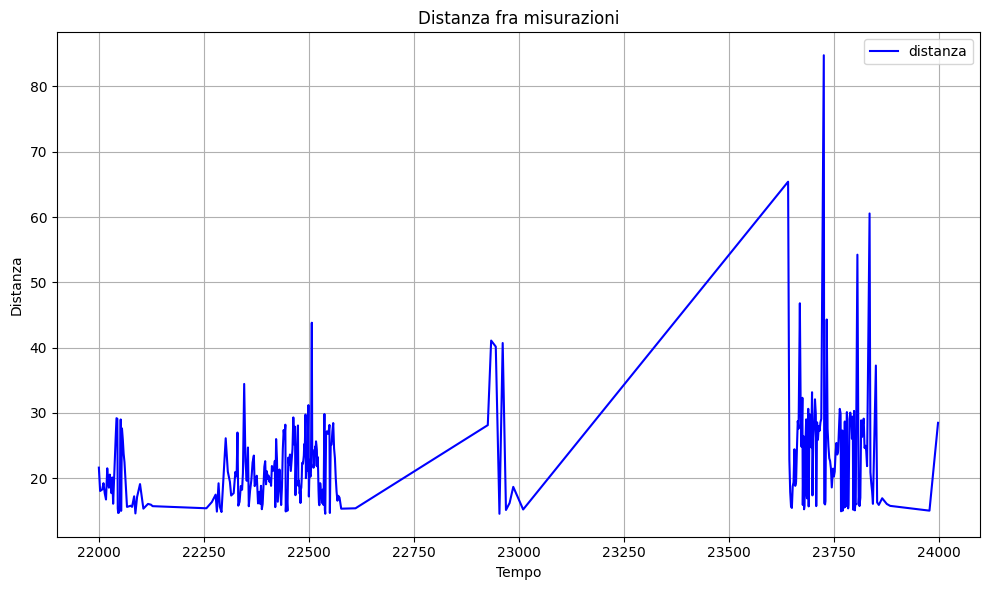

In [577]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['distanza_reale'], 
    label='distanza', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Distanza')
plt.title('Distanza fra misurazioni')
plt.grid(True)
plt.legend()
#plt.ylim(0,200)
#plt.xlim(24300, 24600)  ## max 600 secondi-> 10 minuti di pausa

# Mostrare il grafico
plt.tight_layout()
plt.show()